In [15]:
import os
import re
import json
import bisect
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
DATA_DIR_RAW = '/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/2010_relations_challenge'
DATA_DIR = r'/Users/chenkx/Box Sync/NLP group/2010 i2b2 challenge - rel'
MAP_DIR = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/notebooks/2010Corpus/section_map_v1.csv"

In [48]:
with open(MAP_DIR, 'r') as f:
    section_map = f.read()
section_map = section_map.split('\n')[1:]
section_map = {i.split(',')[0]:i.split(',')[1] for i in section_map}

In [4]:
filenames = [i[:-4] for i in os.listdir(os.path.join(\
    DATA_DIR, "train", "txt")) \
     if i.endswith(".txt")]

In [5]:
file = filenames[0]

In [6]:
with open(os.path.join(DATA_DIR, 'train', 'ref', file+'.ann'), 'r') as f:
    ann = f.readlines()

In [8]:
class Reader:
    def __init__(self, path, fname):
        """
        :param path - Path to the folder of which subfolders include "txt" and "ref"
        """

        self._path = path
        self.fname = fname
        
        self.ann = {}
        self._ann_raw = []
        self.all_headings = []
        
        with open(os.path.join(self._path, "txt", self.fname+".txt"), 'r') as f:
            self.txt = f.read()
        
    def get_all_headings(self):
        matches = re.finditer('[a-zA-Z ]+(( :\n)|( : ))', reader.txt)
        for m in matches:
            match = std_header(m.group(0))
            if match:
                b, e = m.span()
                self.all_headings.append( (match, b, e) )
#         self.all_headings = [std_header(match) for i, match in enumerate([re.search('[a-zA-Z ]+(( :$)|( : ))', txt) for txt in self.txt.split('\n')])]
    
    def get_annotation(self):
        """
        {
            fname: {
                iterm_id: {
                    b: int begin_offset, 
                    e: int end_offset, 
                    t: str "type",
                    a: str "assertion", 
                    c: str "concept_raw_text", 
                    s: str "section"
                }
                length: int length of the note 
            }
        }

        """
        fname = self.fname
        with open(os.path.join(self._path, "ref", fname+".ann"), 'r') as f:
            ann_raw = f.read().split('\n')
            self._ann_raw = ann_raw
        
        annotations = {}
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('T'):
                annotations[line[0]] = {
                    'b': int(line[1].split()[1]),  
                    'e': int(line[1].split()[2]), 
                    't': line[1].split()[0], 
                    'a': None, 
                    'c': line[2], 
                    's': None
                }
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('A'):
                if line[1].split()[1] not in annotations:
                    print(f"Warning: {line[0]} ??")
                annotations[line[1].split()[1]]['a'] = line[1].split()[0]
                
        # remove annotations that don't have assertion informaiton 
        delete = []
        for i in annotations:
            if annotations[i]['a'] is None:
                delete.append(i)
        for i in delete:
            del annotations[i]
        
        annotations['length'] = len(self.txt)
        
        self.ann = {fname: annotations}    

### Pareto chart of section types
Find the top n section types that make up 80% of occurrences.

In [20]:
all_headings = []
for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "train"), file)
    reader.get_all_headings()
    all_headings.extend([i[0] for i in reader.all_headings])

In [21]:
len(set(all_headings))

865

In [ ]:
# Save to disk 
# with open('header_map.json', 'w') as f:
#     for i in sorted(list(set(all_headings))):
#         f.writelines(i + '::' + i + '\n')    

In [22]:
# count the occurances of each section type
heading_count = {}
for i in all_headings:
    if not i:
        continue
    if i not in heading_count:
        heading_count[i] = 0
    heading_count[i] +=1

In [23]:
# remove types that only occur once. Prepare data for plotting
data = sorted(list(heading_count.items()), key=lambda x: -x[1])
for i, e in enumerate(data):
    if e[1] == 1:
        idx = i
        break
data = data[:idx]
section = [x for x, y in data]
cnt = [y for x, y in data]
cumsum = [0]
for i in cnt:
    cumsum.append(cumsum[-1]+i)
cumsum.pop(0)

0

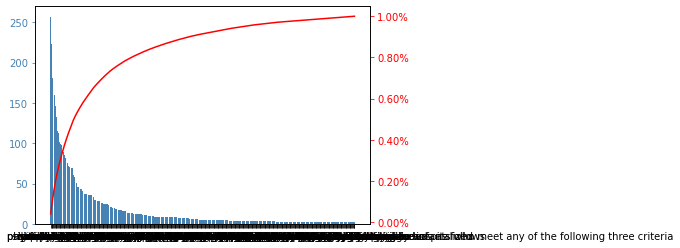

In [24]:
from matplotlib.ticker import PercentFormatter

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(section, cnt, color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(section, [i/sum(cnt) for i in cumsum], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

In [25]:
# keep only the top n section types that make up 80% of all occurrences
n = len([i for i in cumsum if i/sum(cnt) < .8])
data = data[:n+1]
section = section[:n+1]
cnt = cnt[:n+1]

In [26]:
common_sections = section
common_sections[:30]

['medications',
 'date',
 'd',
 't',
 'discharge date',
 'diagnoses',
 'dictated by',
 'hospital course',
 'present illness',
 'past medical history',
 'sex',
 'allergies',
 'physical examination',
 'report status',
 'r',
 'disposition',
 'patient name',
 'service',
 'job id',
 'social history',
 'dictator',
 'mrn',
 'abdomen',
 'date of birth',
 'labs',
 'signed electronically by',
 'attending physician',
 'age',
 'attending',
 'family history']

In [27]:
len(common_sections)

101

### Visualization

In [9]:
all_annot = {}
for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "train"), file)
    reader.get_annotation()
    if not reader.ann:
        print(f'{file} does not contain assertion annotations')
        continue
    all_annot = {**all_annot, **reader.ann}
    

In [10]:
for f in all_annot:
    reader = Reader(os.path.join(DATA_DIR, "train"), f)
    reader.get_all_headings()
    h_left = [i[1] for i in reader.all_headings]
    for i in all_annot[f]:
        if i == 'length':
            continue
        annotation = all_annot[f][i]

        s_i = bisect.bisect_left(h_left, all_annot[f][i]['b']) - 1 
        if s_i == -1:
            section = 'other'
        else:
            section = [i[0] for i in reader.all_headings][s_i]
        all_annot[f][i]['s'] = section

#### Percentage of the 6 assertion types  in each section 

In [11]:
df = pd.DataFrame(columns=['b', 'e', 't', 'a', 'c', 's'])
for f in all_annot:
    for i in all_annot[f]:
        if i == 'length':
            continue
        tmp =pd.DataFrame(all_annot[f][i], index=['::'.join([f, i])])
        df = pd.concat([df, tmp], ignore_index=True)

In [12]:
df.head()

,b,e,t,a,c,s
0,180,215,problem,present,insulin dependent diabetes mellitus,problem list
1,236,266,problem,present,anterior myocardial infarction,problem list
2,281,296,problem,present,pulmonary edema,problem list
3,300,320,problem,present,hypercholesterolemia,problem list
4,391,427,problem,present,prior anterior myocardial infarction,chief complaint


In [165]:
plotdf = None
for i, sec in enumerate(df['s'].value_counts().index):
    if i ==  15:
        break
    s = df[df['s']==sec]['a'].value_counts()
    if plotdf is None:
        plotdf = s.rename(sec)
    else:
        plotdf = pd.concat([plotdf, s.rename(sec)], axis=1)


In [177]:
plotdf = plotdf.fillna(0)

In [76]:
import plotly.graph_objects as go
import plotly.offline as phy

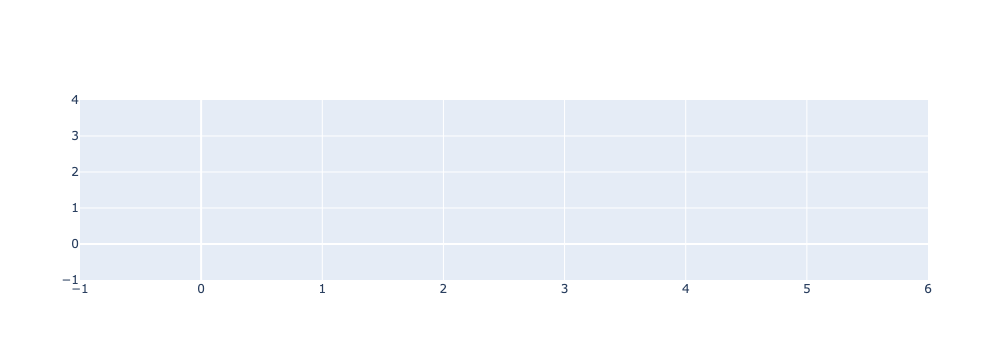

In [163]:
fig = go.Figure()
fig.update_polars(radialaxis=dict(range=[0, 1]))
# categories = ['present', 'absent', 'associated_with_someone_else', \
#               'hypothetical', 'possible', 'conditional']
# fig.add_trace(go.Scatterpolar(
#     r=[0]*5,
#     theta=categories, 
#     fill='toself', 
#     name=''
# ))

hospital course (n=2374)


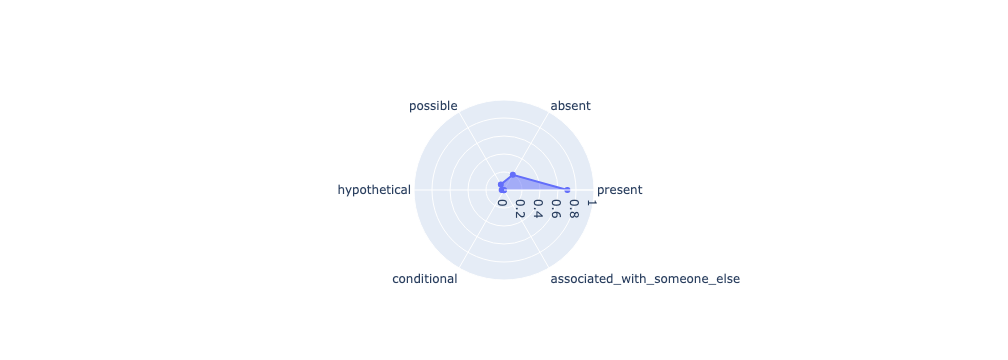

present illness (n=2074.0)


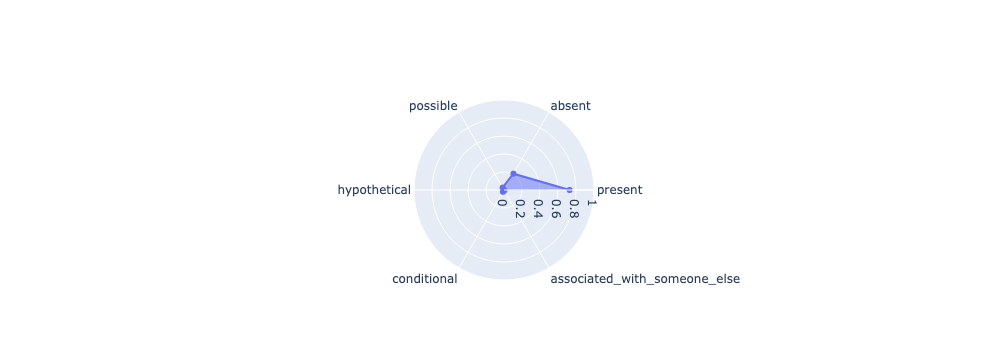

past medical history (n=942.0)


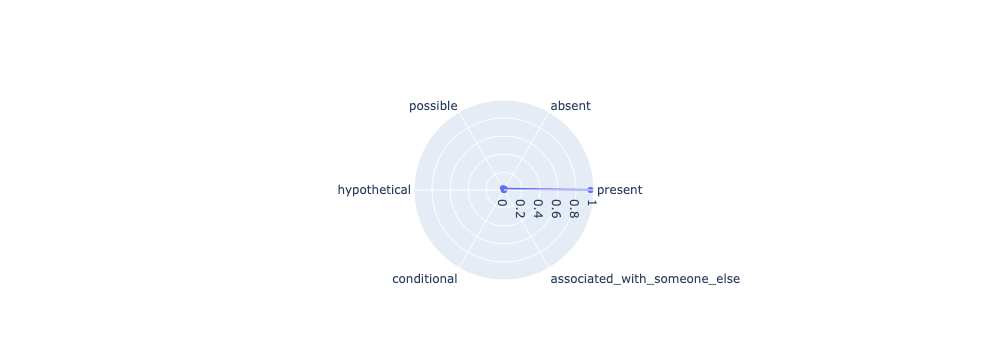

diagnoses (n=936.0)


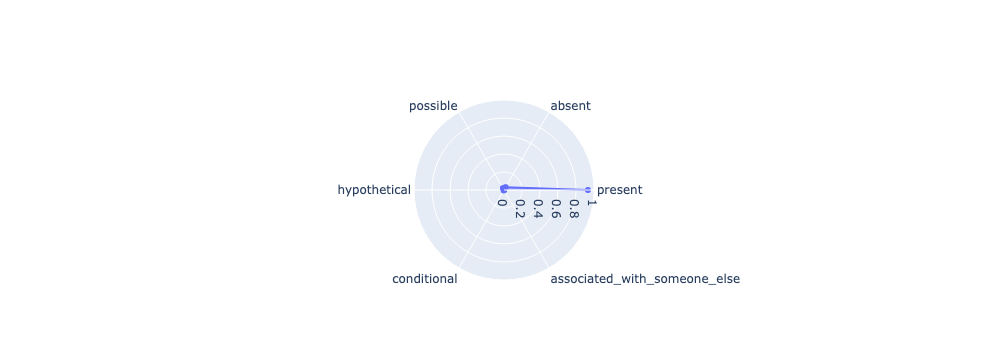

physical examination (n=624.0)


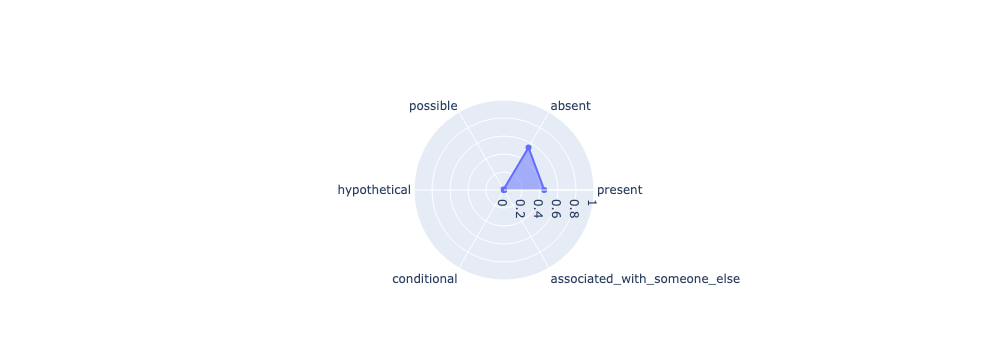

evaluation date (n=368.0)


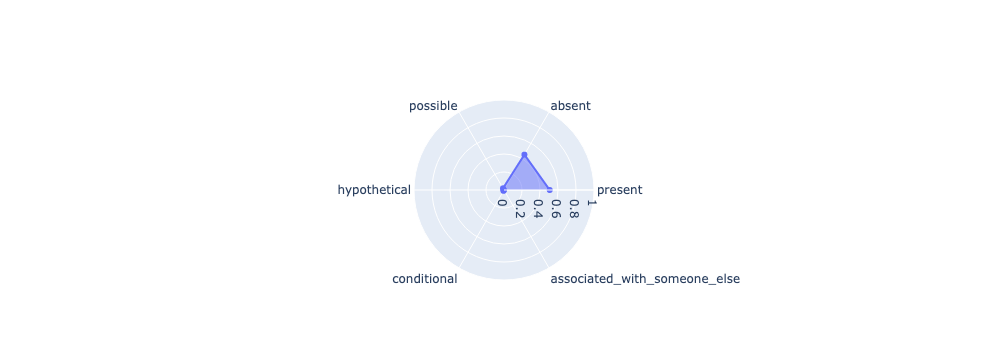

s results (n=341.0)


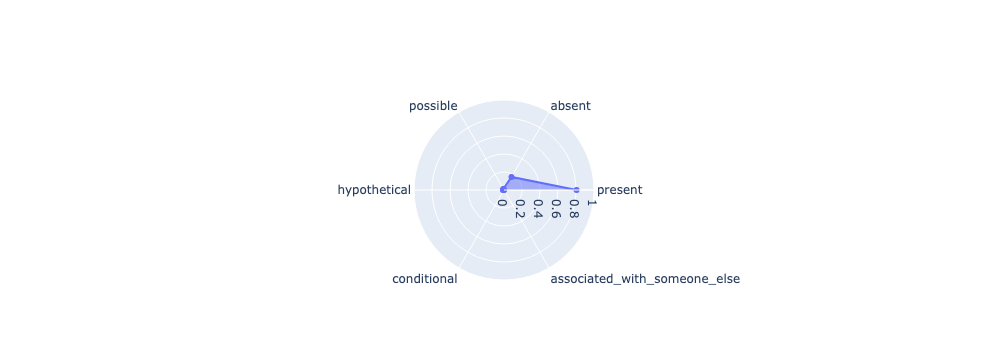

discharge instructions (n=240.0)


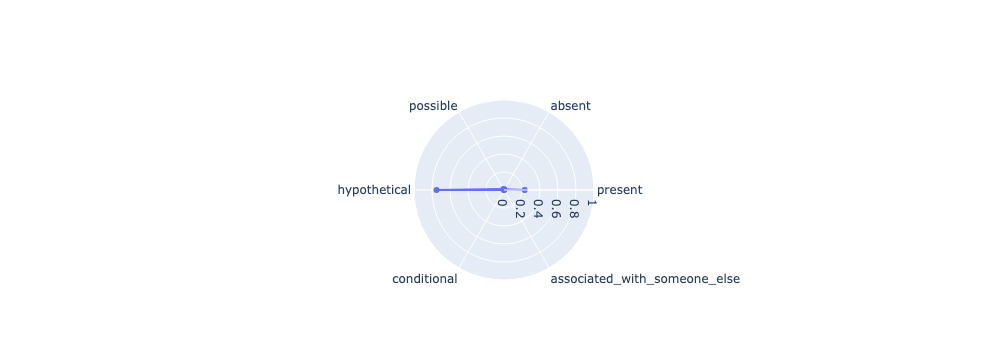

assessment and plan (n=222.0)


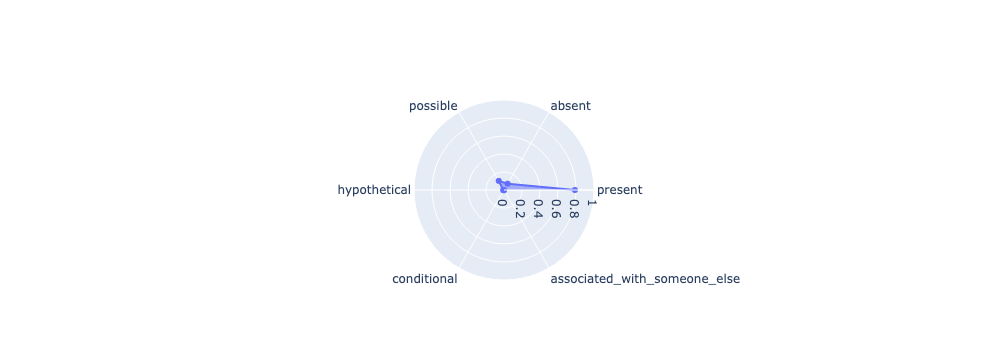

medications (n=222.0)


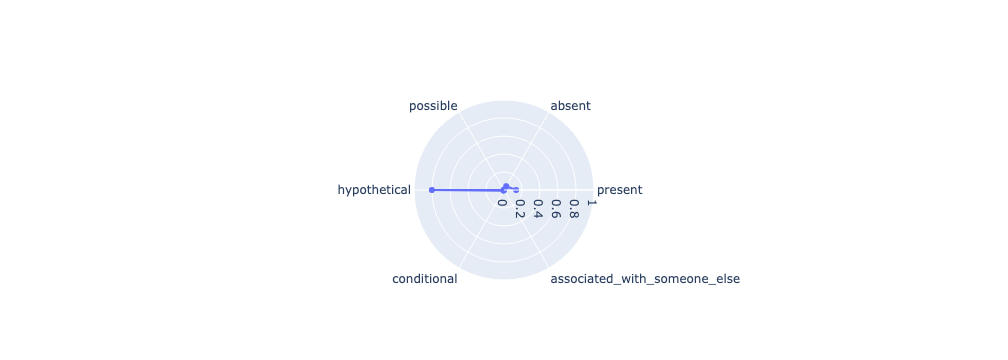

labs (n=209.0)


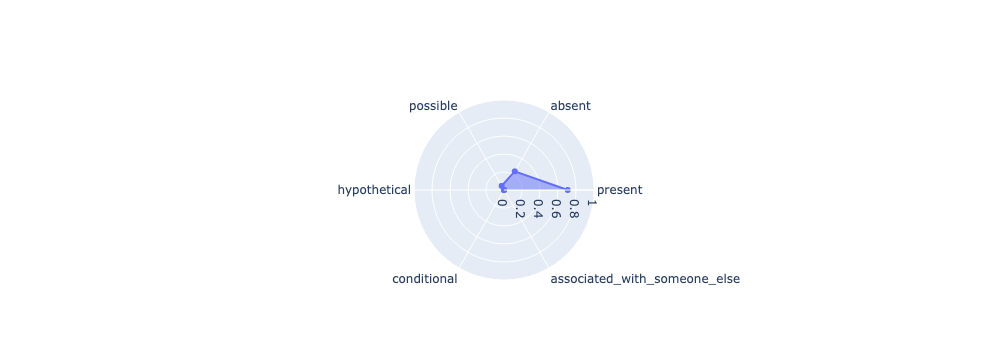

institution course (n=202.0)


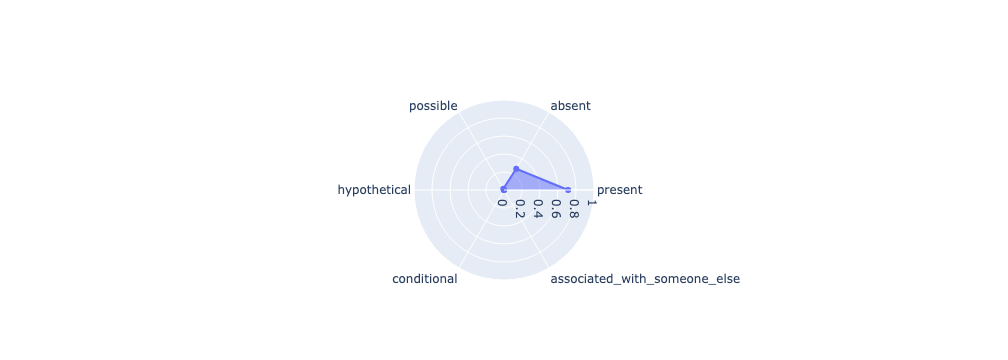

abdomen (n=197.0)


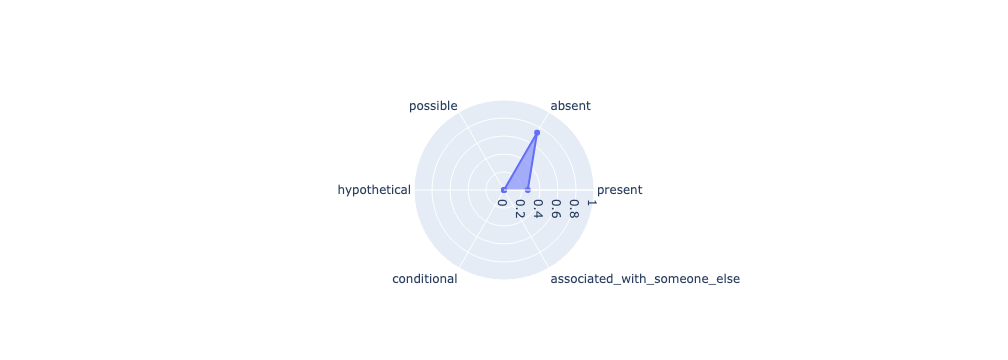

extremities (n=158.0)


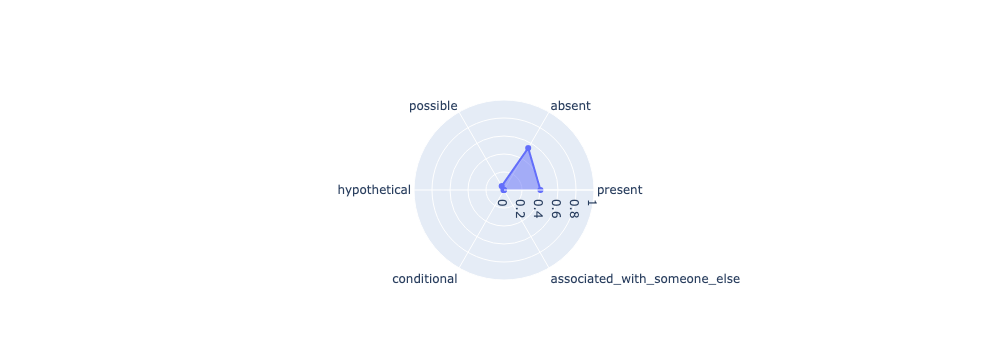

brief hospital course (n=148.0)


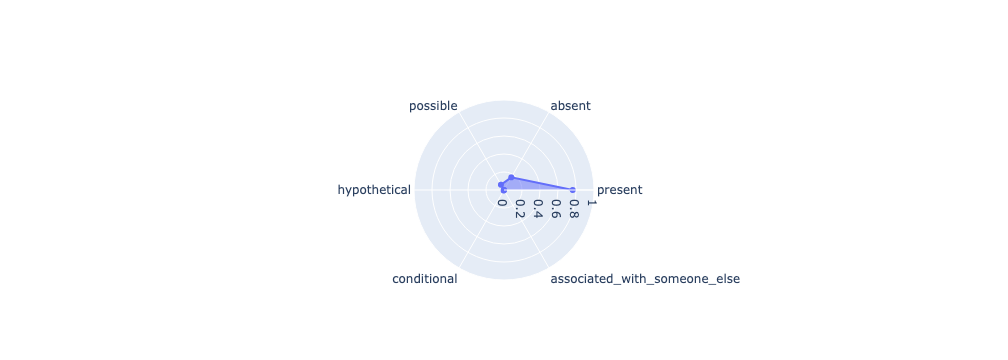

In [179]:
for i in plotdf:
    fig = go.Figure()
    fig.update_polars(radialaxis=dict(range=[0, 1]))
    fig.add_trace(go.Scatterpolar(
        r=plotdf[i]/plotdf[i].sum(),
        theta=plotdf.index, 
        fill='toself', 
        name=i
    ))
    print(f'{i} (n={plotdf[i].sum()})')
    fig.show()

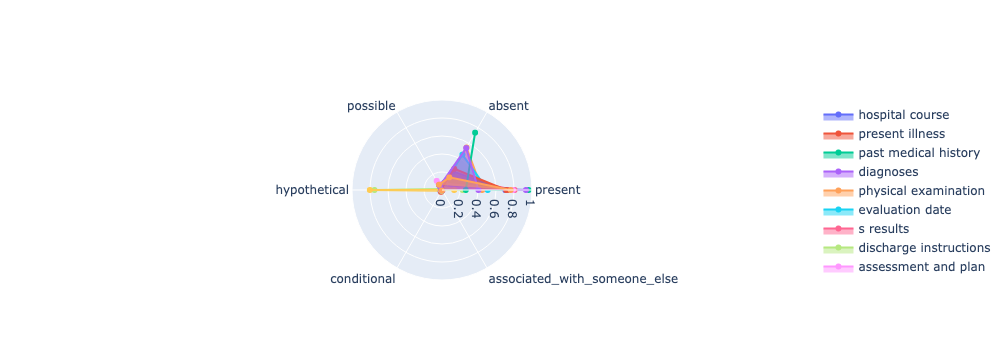

In [171]:
fig.show()

#### Distribution of Contextual Information - Location of Headings 
(Presented in the report of 20221205. Skipped here.)
Fist make sure only concepts whose type is "problem" have assertion info. 
Then show the disctribution of the 6 types of assertion.
Lastly, show the distribution of assertion by section type. Note that only a few section types are selected here. 

In [ ]:
# only concepts of "problem" have annotation of its assertion status
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length': 
            continue
        if annot[i]['t'] != 'problem':
            print(f'{f}: {annot[i]["c"]}')

In [ ]:
ast = []
loc = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        ast.append(annot[i]['a'])
        loc.append(annot[i]['b']/annot['length'])

In [ ]:
df = pd.DataFrame({'ast': ast, 'loc': loc})

In [ ]:
# distribution of negations
import seaborn as sns
sns.displot(df, x='loc', binwidth=.01, col='ast')

In [ ]:
sections = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        sections.append(annot[i]['s'])

In [ ]:
df['sections'] = sections

In [ ]:
df[:3]

In [ ]:
for s in common_sections:
    if s not in df.sections.values:
        continue
    sns.displot(df.loc[df['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()

In [ ]:
for s in common_sections:
    tmp = df.loc[(df['sections']==s) & (df['ast']!= 'present')]
    if len(tmp) < 10:
        continue
    sns.displot(tmp.loc[tmp['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()

In [ ]:
# hexagon 